**Lý thuyết**

Một trong những phương pháp phổ biến nhất được sử dụng trong dự báo chuỗi thời gian được gọi là mô hình ARIMA, viết tắt của mức trung bình di chuyển tích hợp tự động. ARIMA là một mô hình có thể được trang bị cho dữ liệu chuỗi thời gian để hiểu rõ hơn hoặc dự đoán các điểm trong tương lai trong chuỗi.

Có ba số nguyên riêng biệt (p, d, q) được sử dụng để tham số

p là phần tự động hồi quy của mô hình. Nó cho phép chúng ta kết hợp hiệu ứng của các giá trị trong quá khứ vào mô hình. Theo đó, điều này sẽ tương tự như tuyên bố rằng nó có khả năng sẽ ấm áp vào ngày mai nếu nó ấm áp trong 3 ngày qua.

d là phần tích hợp của mô hình. Điều này bao gồm các thuật ngữ trong mô hình kết hợp số lượng khác biệt (nghĩa là số lượng thời gian trong quá khứ để trừ đi giá trị hiện tại) để áp dụng cho chuỗi thời gian. Theo đó, điều này tương tự như tuyên bố rằng nó có khả năng là nhiệt độ tương tự vào ngày mai nếu sự khác biệt về nhiệt độ trong ba ngày qua là rất nhỏ.

q là phần trung bình di chuyển của mô hình. Điều này cho phép chúng ta đặt lỗi của mô hình như là sự kết hợp tuyến tính của các giá trị lỗi được quan sát tại các thời điểm trước trong quá khứ.

SARIMAX(Trung bình di chuyển tích hợp tự động hồi quy theo mùa với các yếu tố ngoại sinh) là phiên bản cập nhật của mô hình ARIMA. ARIMA bao gồm đường trung bình động tích hợp tự hồi quy, trong khi SARIMAX bao gồm các tác động theo mùa và các yếu tố ngoại sinh với thành phần đường trung bình động và tự hồi quy trong mô hình.

Khi xử lý các hiệu ứng theo mùa, chúng ta sử dụng Sarimax, được ký hiệu là Arima (p, d, q) (P, D, Q) s.

Ở đây, (p, d, q) là các tham số không theo mùa được mô tả ở trên, trong khi (P, D, Q) tuân theo cùng một định nghĩa nhưng được áp dụng cho thành phần theo mùa của chuỗi thời gian.

Thuật ngữ S là tính tuần hoàn của chuỗi thời gian (4 cho các khoảng thời gian hàng quý, 12 cho các khoảng thời gian hàng năm, v.v.).

Phương pháp SARIMAX  có thể xuất hiện khó khăn vì nhiều tham số điều chỉnh liên quan.

In [64]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



#Phân chia tập train, test, validate


In [65]:
# 2. Đọc file dữ liệu chứng khoán DELL và chia train test validate theo tỉ lệ 7:1:2
d01 = pd.read_csv('/content/2357.TW.csv')
d1 = d01[['Close']]
d1 = d1.dropna() # Drop missing values
d1['Date'] = pd.to_datetime(d01['Date'])
d1.set_index('Date', inplace=True)
#d1 = d1.reset_index(drop=True) # Reset the index


In [66]:
# 2. Đọc file dữ liệu chứng khoán khác
d02 = pd.read_csv('/content/MSFT.csv')
d2 = d02[['Close']]
d2 = d2.dropna() # Drop missing values
#d2 = d2.reset_index(drop=True) # Reset the index
d2['Date'] = pd.to_datetime(d02['Date'])
d2.set_index('Date', inplace=True)


In [67]:
d2.rename(columns={'Close':'Close1'}, inplace=True)

In [68]:
df = pd.merge(d2, d1, on='Date')


In [69]:
df = df[['Close','Close1']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [70]:

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

#Kiếm tra yếu tố mùa vụ


Trong một số chuỗi thời gian thường xuất hiện yếu tố mùa vụ. Việc tìm ra chu kì và qui luật mùa vụ sẽ giúp cho mô hình dự báo chuẩn xác hơn. Chúng ta có thể dễ dàng phát hiện ra chúng thông qua đồ thị của chuỗi.

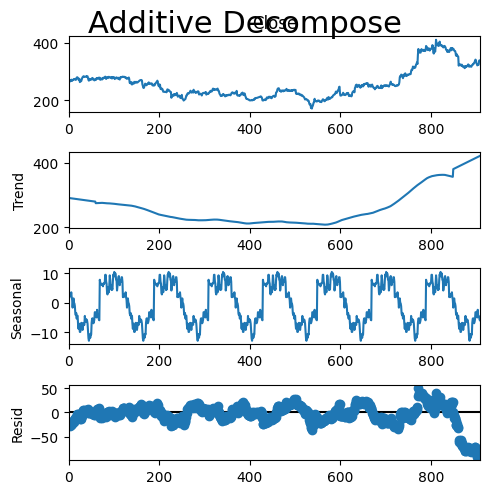

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(train_data['Close'], model='additive', extrapolate_trend='freq', period=120)
plt.rcParams.update({'figure.figsize': (5,5)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

#Kiem tra tinh dung

In [72]:
#Để biết thêm về tính dừng của chuỗi thời gian, chúng ta có thể thực hiện kiểm định ADfuller, một kiểm định dựa trên giả thuyết,
# trong đó nếu giá trị p nhỏ hơn 0,05 thì chúng ta có thể coi chuỗi thời gian là dừng
# và nếu giá trị P là lớn hơn 0,05 thì chuỗi thời gian không dừng.

In [73]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(train_data['Close'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -0.6956825723571828
2. P-Value :  0.8478646816412867
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 905
5. Critical Values :
	 1% :  -3.437596348122793
	 5% :  -2.86473892523805
	 10% :  -2.5684733191905007


In [74]:
#Ở đây, chúng ta có thể thấy rằng giá trị p>0.05 cao hơn đối với tập dữ liệu của chúng ta và chúng ta có thể nói rằng bằng chứng của giả thuyết khống là thấp;
#do đó chuỗi thời gian là không cố định.Chúng ta có thể làm cho chuỗi thời gian đứng yên bằng các phương pháp khác biệt.

# Tự tương quan(ACF) và tự tương quan riêng phần (PACF)

Hệ số tự tương quan được viết tắt là ACF và thường dùng để tìm ra độ trễ của quá trình trung bình trượt
 để xây dựng các mô hình như ARIMA, GARCH, ARIMAX,… và kiểm tra yếu tố mùa vụ.

Hệ số tự tương quan riêng phần PACF về cơ bản cũng là chỉ số đo lường hệ số tương quan như ACF. Tuy nhiên vẫn có sự khác biệt đó là hệ số tương quan này loại bỏ ảnh hưởng của các chuỗi độ trễ trung gian

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


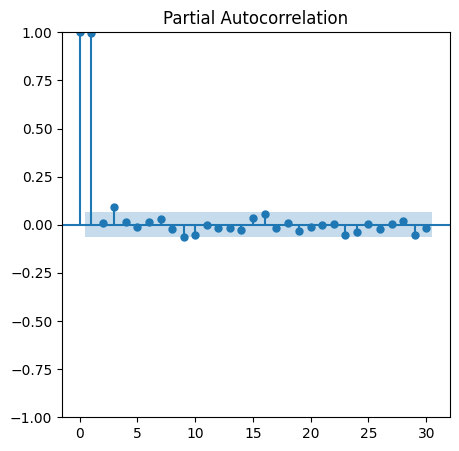

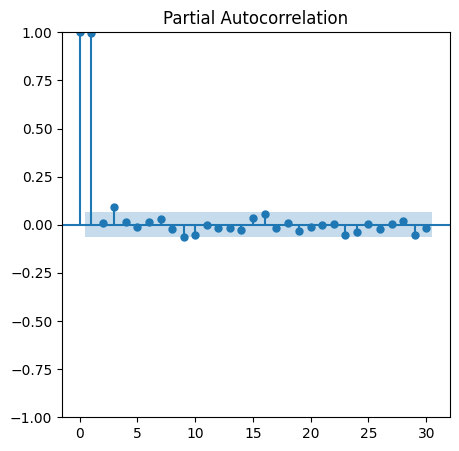

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_pacf(train_data['Close'])

Nhận xét dựa vào biểu đồ ACF phân rã chậm, biểu đồ PACF chi tương quan 1 phần chỉ có 1 điểm tăng đột biến ở chân cột
=> Không cố định

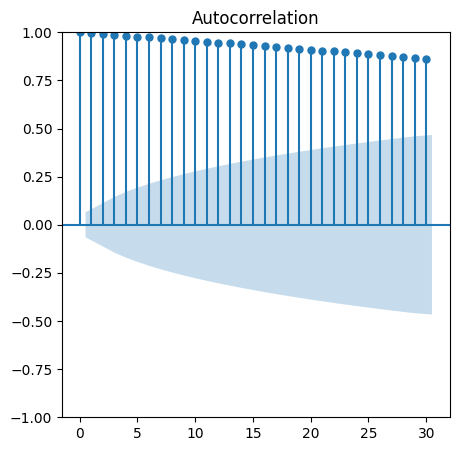

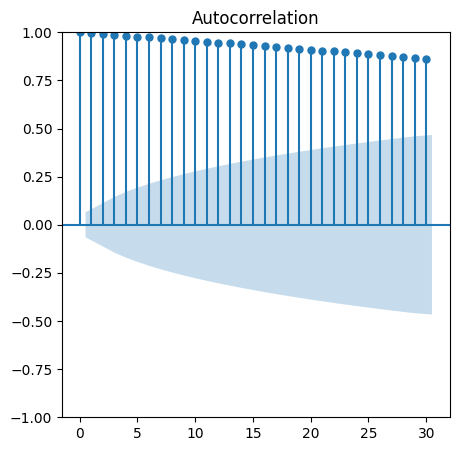

In [76]:
plot_acf(train_data['Close'])


Như vậy từ biểu đồ ta có thể lựa chọn bậc tự tương quan riêng phần PACF và tự tương quan ACF là các giá trị nhỏ hơn hoặc bằng 5. Do chuỗi có trend nên chúng ta sẽ lấy sai phân bậc 1 để tạo chuỗi dừng, hay nói cách khác bậc của intergration
. Ngoài ra chúng ta cần phải xác định thêm các bậc
 của yếu tố mùa vụ được trích xuất từ chuỗi ban đầu. Để mô hình hiểu được chúng ta đang hồi qui trên mô hình SARIMA thì cần thiết lập tham số seasonal=True và chu kì của mùa vụ m=12.

#Lựa chọn tham số SARIMAX(p, d, q)(P,D,Q)s

In [77]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
# 3. Quá trình Training
x_train = np.array(train_data).reshape(-1, 1)
y_train = np.array(train_data['Close'])
# Find the best SARIMAX model using auto_arima
from pmdarima import auto_arima

model = auto_arima(y_train, start_p=0, start_q=0, exogenous = train_data['Close1'],
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(model.aic())
#Trong đó:

#y_train là chuỗi dữ liệu cần được xử lý.
#seasonal=True định nghĩa chuỗi dữ liệu có một chu kỳ mùa (seasonality) hay không.

#suppress_warnings=True loại bỏ thông báo cảnh báo.
#error_action="ignore" sẽ bỏ qua các giá trị không xử lý được.
#stepwise=True nếu muốn tìm kiếm các giá trị tham số theo phương pháp tìm kiếm thích ứng (adaptive search).
#Cuối cùng, ta chọn các giá trị p, q, và l được xác định bởi hàm auto_arima để tạo mô hình SARIMAX tốt nhất cho chuỗi dữ liệu.



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5772.568, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5551.997, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5772.846, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5443.287, Time=1.80 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5441.995, Time=2.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5550.943, Time=1.21 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=9.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5443.163, Time=1.71 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=12.82 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5443.990,

Đó chính là mô hình SARIMAX(p=0, d=1, q=0)(p=2, D=1, q=0, m=12). Mô hình cho kết quả khá tốt khi các hệ số hồi qui đều có ý nghĩa thống kê (toàn bộ cột P>|z| đều nhỏ hơn 0.05).

> Vì vậy, chúng ta có mô hình với thuật ngữ ngoại sinh. Nhưng hệ số này rất nhỏ đối với x1, vì vậy đóng góp từ biến đó sẽ không đáng kể.



In [79]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  909
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2717.998
Date:                            Fri, 16 Jun 2023   AIC                           5441.995
Time:                                    17:29:57   BIC                           5456.389
Sample:                                         0   HQIC                          5447.495
                                            - 909                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6350      0.022    -28.555      0.000      -0.679      -0.591
ar.S.L24      -0.3425      0.021   

#Dự báo

In [80]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [81]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[341.88755875 340.79271727 339.8201865  337.76115162 335.80985452
 336.35339143 338.53343619 338.01970157 339.19211297 346.01490115
 346.08367118 345.24868049 349.47512085 349.92793332 348.3029845
 344.28403701 342.69430823 342.80024131 345.4759359  345.28841031
 346.62259699 353.20788423 354.38169733 355.10437472 359.66787806
 360.71165388 359.14907704 353.65492742 351.47644153 349.9616379 ]


In [82]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 103.99864991836029
Testing RMSE: 143.43721044043536


Validation RMSE: 103.99864991836029
Testing RMSE: 143.43721044043536
Validation MAE: 102.47947322109933
Testing MAE: 105.53965821763009
Validation MAPE: 0.3670603707821599
Testing MAPE: 0.38823790714629314


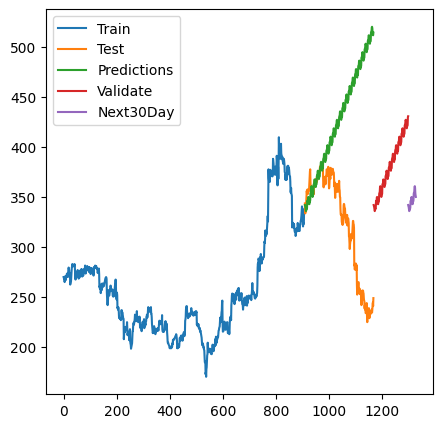

In [83]:

# 8. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mae= np.mean(np.abs(y_pred_val - y_val))
test_mae= np.mean(np.abs(y_pred - y_test))
valid_mape= np.mean(np.abs((y_pred_val - y_val) / y_val))
test_mape= np.mean(np.abs((y_pred - y_test) /y_test))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [84]:
test_data.index

RangeIndex(start=909, stop=1168, step=1)